In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
def getCalibrationInfo(file):
    calibration = pd.read_csv(file, skiprows=20, names=['PitotVel', 'HotWireEv'])
    PitotVel = np.array(calibration['PitotVel'])
    Voltage = np.array(calibration['HotWireEv'])
    file_coeff = pd.read_csv('calibration_curve', skiprows=15, nrows=1)
    fixed_coeff = np.flip(np.array(file_coeff).reshape((5,)))
    return PitotVel, Voltage, fixed_coeff

def getVelocityProfile(file):
    return pd.read_csv(file, skiprows=16, names=['LateralPos', 'PitotVel', 'PitotVelStd', 'HotWireVel', 'HotWireVelStd'])

def computeInfo(frame, series):
    U = np.mean([frame[series][:3], frame[series][-3:]])
    y_0 = frame.loc[frame[series].idxmin(), 'LateralPos']
    Y = (frame['LateralPos'] - y_0) / 120
    return U, Y

def getTransient(file):
    return np.array(pd.read_excel(file, header=None, skiprows=1, engine='openpyxl'))

def computeFFT(file):
#     data = np.mean(getTransient(file), axis=-1)
    data = getTransient(file).flatten('F')
    sp = np.fft.fft(data)
    freq = np.fft.fftfreq(len(data), 1/8000)
    domain = np.nonzero(freq > 0.)
    peak = freq[np.argmax(sp[domain])]
    return sp, freq, peak

In [3]:
UP, EV, cal_coeff = getCalibrationInfo('calibration_curve')

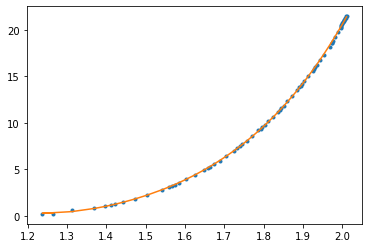

In [4]:
plt.plot(EV, UP, '.')
plt.plot(EV, np.polyval(cal_coeff, EV))

In [5]:
VP_X1 = getVelocityProfile('velocity_profile_x1')
VP_X3 = getVelocityProfile('velocity_profile_x3')
VP_X4 = getVelocityProfile('velocity_profile_x4')

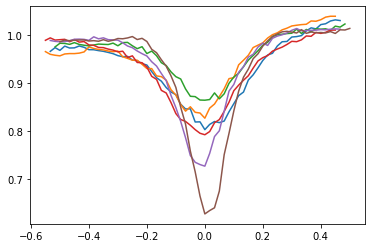

In [6]:
U1H, Y1H = computeInfo(VP_X1, 'HotWireVel')
U3H, Y3H = computeInfo(VP_X3, 'HotWireVel')
U4H, Y4H = computeInfo(VP_X4, 'HotWireVel')
U1P, Y1P = computeInfo(VP_X1, 'PitotVel')
U3P, Y3P = computeInfo(VP_X3, 'PitotVel')
U4P, Y4P = computeInfo(VP_X4, 'PitotVel')
plt.plot(Y1H, VP_X1['HotWireVel']/U1H)
plt.plot(Y3H, VP_X3['HotWireVel']/U3H)
plt.plot(Y4H, VP_X4['HotWireVel']/U4H)
plt.plot(Y1P, VP_X1['PitotVel']/U1P)
plt.plot(Y3P, VP_X3['PitotVel']/U3P)
plt.plot(Y4P, VP_X4['PitotVel']/U4P)
# Format
# ...

In [ ]:
#reynolds number calculation,drag force, coefficient of drag
T = 21.5 #celsius
T = T+273.15
P = 98.5*10**3 #Pa
R = 287 #J/kg*K
T0 = 288.16667 #K
mu0 = 0.00001733265 #Pa-s

rho = P/R/T
V = [[10,13,16,19,20]] #m/s
mu = mu0*(T/T0)**(1.5)*((T0+198.72)/(T+198.72)) #Pa-s
D = [[19.05/1000,12.07/1000]] #m
w = 300/1000 #m
L = 60/1000 #m

A = np.zeros_like(D)
for i in range(0,len(D[0])):
    A[:,i] = w*A[0][i]

Re1 = np.zeros_like(V)
Re2 = np.zeros_like(V)
for i in range(0,len(V[0])):
    Re1[:,i] = rho*V[0][i]*D[0][0]/mu
for i in range(0,len(V[0])):
    Re2[:,i] = rho*V[0][i]*D[0][1]/mu
print(Re1[0])
print(Re2[0])
#FD = 0
q = np.zeros_like(V)
for i in range(0,len(V[0])):
    q[:,i] = 1/2*rho*V[0][i]**2
print(q[0])
#Cd = FD/(q*A)


FFT_10.xlsx: 96.25
FFT_13.xlsx: 128.59375
FFT_16.xlsx: 159.375
FFT_19.xlsx: 191.71875
FFT_22.xlsx: 213.90625


(0.0, 35000.0)

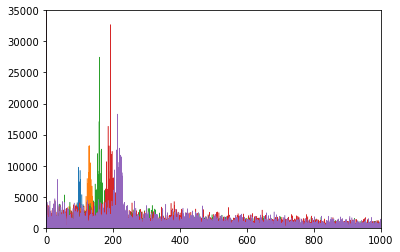

In [7]:
large_FFT_files = ['FFT_10.xlsx', 'FFT_13.xlsx', 'FFT_16.xlsx', 'FFT_19.xlsx', 'FFT_22.xlsx']
peaks = []
for file in large_FFT_files:
    sp, freq, peak = computeFFT(file)
    peaks.append(peak)
    print(file+':', peak)
    plt.plot(freq, sp.real, linewidth=0.5)
plt.xlim((0, 1000))
plt.ylim((0, 35000))

In [8]:
all_files = ''.join(large_FFT_files)
vels = [int(s) for s in re.findall(r'\d+', all_files)]
d = 19.05/1000
St = np.array(peaks) * d / np.array(vels)
print(St)

[0.18335625 0.1884393  0.18975586 0.19222327 0.18522337]


In [88]:
#reynolds number calculation
T = 21.5 #celsius
T = T+273.15
P = 98.5*10**3 #Pa
R = 287 #J/kg*K
T0 = 288.16667 #K
mu0 = 0.00001733265 #Pa-s

rho = P/R/T
V = [[10,13,16,19,20]] #m/s
mu = mu0*(T/T0)**(1.5)*((T0+198.72)/(T+198.72)) #Pa-s
D = [[19.05/1000,12.07/1000]] #m
w = 300/1000 #m

A = np.zeros_like(D)
for i in range(0,len(D[0])):
    A[:,i] = w*A[0][i]

Re1 = np.zeros_like(V)
Re2 = np.zeros_like(V)
for i in range(0,len(V[0])):
    Re1[:,i] = rho*V[0][i]*D[0][0]/mu
for i in range(0,len(V[0])):
    Re2[:,i] = rho*V[0][i]*D[0][1]/mu
print(Re1[0])
print(Re2[0])
#FD = 0
q = np.zeros_like(V)
for i in range(0,len(V[0])):
    q[:,i] = 1/2*rho*V[0][i]**2
print(q[0])
#Cd = FD/(q*A)



[12546 16310 20074 23838 25093]
[ 7949 10334 12719 15104 15899]
[ 58  98 149 210 232]
